# Coronavirus/COVID-19 Timseries Forecasting

- ~~[GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)~~
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

> **~~NOTE: DATA ACQUISITION IS BEING RE-WORKED IN "Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipnynb"~~** -08/12/21

In [1]:
RUN_FULL_WORKFLOW=True

In [2]:
import sys
'google' in sys.modules

True

In [3]:
# del sys.modules['google']

In [4]:
'google' in sys.modules

True

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coronavirus/COVID-19-Timseries-Forecasting" data-toc-modified-id="Coronavirus/COVID-19-Timseries-Forecasting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coronavirus/COVID-19 Timseries Forecasting</a></span></li><li><span><a href="#Business-Problem" data-toc-modified-id="Business-Problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Business Problem</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Methodology</a></span></li></ul></li></ul></li><li><span><a href="#OBTAIN" data-toc-modified-id="OBTAIN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OBTAIN</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Project-Control-Booleans" data-toc-modified-id="Project-Control-Booleans-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Project Control Booleans</a></span></li></ul></li></ul></li><li><span><a href="#[To-Be-Updated]-COPIED-legacy-book-2-on--09/06/21" data-toc-modified-id="[To-Be-Updated]-COPIED-legacy-book-2-on--09/06/21-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>[To Be Updated] COPIED legacy book 2 on  09/06/21</a></span></li><li><span><a href="#EDA---Comparing-States" data-toc-modified-id="EDA---Comparing-States-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA - Comparing States</a></span><ul class="toc-item"><li><span><a href="#FL" data-toc-modified-id="FL-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FL</a></span><ul class="toc-item"><li><span><a href="#Calc-Delta-Cases/Deaths" data-toc-modified-id="Calc-Delta-Cases/Deaths-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Calc Delta Cases/Deaths</a></span></li></ul></li></ul></li><li><span><a href="#Time-Series-Modeling" data-toc-modified-id="Time-Series-Modeling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Time Series Modeling</a></span><ul class="toc-item"><li><span><a href="#MD" data-toc-modified-id="MD-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>MD</a></span><ul class="toc-item"><li><span><a href="#MD---Cases-New" data-toc-modified-id="MD---Cases-New-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>MD - Cases-New</a></span></li><li><span><a href="#MD---Hospitalized-Currently" data-toc-modified-id="MD---Hospitalized-Currently-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>MD - Hospitalized Currently</a></span></li></ul></li><li><span><a href="#🚨-BOOKMARK:-Data-Quality-Issue---Deaths" data-toc-modified-id="🚨-BOOKMARK:-Data-Quality-Issue---Deaths-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>🚨 BOOKMARK: Data Quality Issue - Deaths</a></span><ul class="toc-item"><li><span><a href="#MD---Deaths-New" data-toc-modified-id="MD---Deaths-New-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>MD - Deaths-New</a></span></li></ul></li></ul></li><li><span><a href="#Function-For-Any-Given-State/-Column" data-toc-modified-id="Function-For-Any-Given-State/-Column-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Function For Any Given State/ Column</a></span><ul class="toc-item"><li><span><a href="#✔-TO-DO:-make-remove_outliers-into-a-helper-function" data-toc-modified-id="✔-TO-DO:-make-remove_outliers-into-a-helper-function-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span><strong>✔ TO DO: make remove_outliers into a helper function</strong></a></span></li></ul></li><li><span><a href="#@interact" data-toc-modified-id="@interact-8"><span class="toc-item-num">8&nbsp;&nbsp;</span><code>@interact</code></a></span></li><li><span><a href="#APPENDIX" data-toc-modified-id="APPENDIX-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>APPENDIX</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#def-modeling-functions" data-toc-modified-id="def-modeling-functions-9.0.1"><span class="toc-item-num">9.0.1&nbsp;&nbsp;</span><code>def</code> modeling functions</a></span></li></ul></li></ul></li></ul></div>

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

- See `data_acquisition.py`> `FULL_WORKFLOW()` and `1_Replacing Covid Tracking Project - Simplified Workflow.ipynb` for details (for now)


# OBTAIN

## Imports

In [5]:
!pip install -U pmdarima
!pip install -U fsds

from fsds.imports import *

fsds v0.4.2 loaded.


Package,Handle,Version,Documentation,Imported
pandas,pd,1.1.3,https://pandas.pydata.org/docs/,Y
fsds,fs,0.4.2,https://fs-ds.readthedocs.io/en/latest/,Y
numpy,np,1.19.5,https://numpy.org/doc/stable/reference/,Y
matplotlib,mpl,3.3.1,https://matplotlib.org/stable/api/index.html,Y
matplotlib.pyplot,plt,,https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot,Y
seaborn,sns,0.11.0,https://seaborn.pydata.org/api.html,Y
IPython.display,dp,,https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html,Y
sklearn,,0.23.2,,N


In [6]:
import os,glob,sys,joblib,zipfile,json
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)
# fs.check_package_versions(['statsmodels'],fpath=True)

In [7]:
### FORECAST SPECIFIC FUNCTIONS
import statsmodels.api as sms
import statsmodels.tsa.api as tsa
from pmdarima import auto_arima

In [8]:
import statsmodels
print(f"Statsmodels version: {statsmodels.__version__}")

import pmdarima
print(f"pmdarima version: {pmdarima.__version__}")

Statsmodels version: 0.12.2
pmdarima version: 1.8.2


In [9]:
## Custom Functions and Classes
%load_ext autoreload
%autoreload 2
# import project_functions as fn
import fsds.pandemic as fn

## Data

In [10]:
## Using new savedd FILE_DIRECTORIES
import os,json,glob

with open("FILE_DIRECTORY.json") as f:
    FPATHS = json.load(f)
FPATHS

{'fpath_raw': './data_raw/',
 'fpath_clean': './data/',
 'fpath_reference': './reference_data/',
 'fpath_state_data': './data/state_data/',
 'fpath_final_states': './data/FINAL_STATES.joblib',
 'fpath_final_df_csv': './data/FINAL_STATES.csv.gz',
 'fpath_final_df_pickle': './data/FINAL_STATES.pickle',
 'name_of_fpath_vars': ['fpath_raw',
  'fpath_clean',
  'fpath_reference',
  'fpath_state_data',
  'fpath_final_states',
  'fpath_final_df_csv',
  'fpath_final_df_pickle',
  'name_of_fpath_vars']}

In [11]:
for path_name,fpath in FPATHS.items():
    try:
        
        found_files =  sorted(os.listdir(fpath))
        print(f"\n[i] Files stored in {path_name}:")
        [print("\t",i,x) for i,x in enumerate(found_files)]
    except:
        pass



[i] Files stored in fpath_raw:
	 0 .ipynb_checkpoints
	 1 CONVENIENT_us_metadata.csv
	 2 RAW_us_confirmed_cases.csv
	 3 RAW_us_deaths.csv
	 4 covid19-data-from-john-hopkins-university.zip
	 5 hospital_data.csv

[i] Files stored in fpath_clean:
	 0 COLUMNS.joblib
	 1 FINAL_STATES.csv.gz
	 2 FINAL_STATES.joblib
	 3 FINAL_STATES.pickle
	 4 STATE_DICT.joblib
	 5 combined_us_states_full_data.csv
	 6 state_data
	 7 us_states_cases_deaths.csv
	 8 us_states_daily_cases_deaths.csv

[i] Files stored in fpath_reference:
	 0 COLUMNS.joblib
	 1 population-by-country-2020.zip
	 2 state_codes_to_names_map.joblib
	 3 state_names_to_codes_map.joblib
	 4 united_states_abbreviations.csv
	 5 us_metadata_counties.csv
	 6 us_metadata_states.csv

[i] Files stored in fpath_state_data:


### Project Control Booleans

In [12]:
RUN_FULL_WORKFLOW=True

In [13]:
# ## making mapper dict to rename new columns
# new_to_match_old_map = {
#     'Deaths':'death',
#     'Cases':'positive',
#     'total_adult_patients_hospitalized_confirmed_covid':'hospitalizedCurrently',
# 'adult_icu_bed_covid_utilization_numerator':'inIcuCurrently'}
# ## making mapper dict to rename new columns
# new_to_final_names = {
#     'Deaths':'Deaths',
#     'Cases':'Cases',
#     'total_adult_patients_hospitalized_confirmed_covid':'Hospitalized Currently',
# 'adult_icu_bed_covid_utilization_numerator':'ICU-Covid Currently'}
# list(new_to_final_names.keys())

In [14]:
FPATHS

{'fpath_raw': './data_raw/',
 'fpath_clean': './data/',
 'fpath_reference': './reference_data/',
 'fpath_state_data': './data/state_data/',
 'fpath_final_states': './data/FINAL_STATES.joblib',
 'fpath_final_df_csv': './data/FINAL_STATES.csv.gz',
 'fpath_final_df_pickle': './data/FINAL_STATES.pickle',
 'name_of_fpath_vars': ['fpath_raw',
  'fpath_clean',
  'fpath_reference',
  'fpath_state_data',
  'fpath_final_states',
  'fpath_final_df_csv',
  'fpath_final_df_pickle',
  'name_of_fpath_vars']}

In [15]:
os.listdir(FPATHS['fpath_clean'])

['us_states_daily_cases_deaths.csv',
 'state_data',
 'combined_us_states_full_data.csv',
 'us_states_cases_deaths.csv',
 'STATE_DICT.joblib',
 'FINAL_STATES.joblib',
 'FINAL_STATES.csv.gz',
 'COLUMNS.joblib',
 'FINAL_STATES.pickle']

In [16]:
## Uncomment Cell to acquire new data
if RUN_FULL_WORKFLOW:
    df_states,STATES = fn.data_acquisition.FULL_WORKFLOW(merge_hospital_data=True)
    ## renaming since merge_hofspital_data=True
#     DF = df_states.copy()
#     print(STATES.keys())    
    
else:
    print(f"[i] Using previously downloaded data...")
    df_states = pd.read_pickle(FPATHS['fpath_final_df_pickle'])
    
#     with open(FPATHS['fpath_final_states']) as f:
    STATES = joblib.load(FPATHS['fpath_final_states'])
#     df_states = pd.read_csv(os.path.join(fpath_clean,
#                                          'combined_us_states_full_data.csv'))
#     STATES = joblib.load(os.path.join(fpath_clean,'STATE_DICT.joblib'))

display(df_states.head())
print(STATES.keys())

========= RUNNING FULL WORKFLOW =========
[i] Retrieving kaggle dataset: antgoldbloom/covid19-data-from-john-hopkins-university
- Loading data from RAW_us_confirmed_cases.csv
- Loading data from RAW_us_deaths.csv
[i] Retrieving hospital data from https://healthdata.gov/resource/g62h-syeh.csv
[i] Workflow completed.
	Run time=0:00:56.887722 sec.
[i]The final files of note:
	./data/combined_us_states_full_data.csv
	./data/STATE_DICT.joblib
[i] Final joined data (DF) saved as ./data/FINAL_STATES.csv.gz
[i] Final joined data (DF) saved as ./data/FINAL_STATES.pickle


Deaths  Cases  ...  Deaths-New  Cases-New
   Date                       ...                       
AK 2020-03-23       0     39  ...         0.0        0.0
   2020-03-24       0     43  ...         0.0        4.0
   2020-03-25       1     50  ...         1.0        7.0
   2020-03-26       1     64  ...         0.0       14.0
   2020-03-27       1     75  ...         0.0       11.0

[5 rows x 6 columns]

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])


# [To Be Updated] COPIED legacy book 2 on  09/06/21

# EDA - Comparing States

## FL

In [17]:
FL = STATES['FL'].copy()
FL

,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-03-12,2,30,0.0,0.0,0.0,0.0
2020-03-13,2,50,0.0,0.0,0.0,20.0
2020-03-14,2,76,0.0,0.0,0.0,26.0
2020-03-15,3,100,0.0,0.0,1.0,24.0
2020-03-16,3,101,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2021-09-04,46324,3352451,13228.0,3160.0,2345.0,129202.0
2021-09-05,46324,3352451,13172.0,3139.0,0.0,0.0
2021-09-06,46324,3352451,13136.0,3115.0,0.0,0.0


In [18]:
## first non-null hospital timestamps
first_ts = FL[FL['Hospitalized Currently'].notna()].index[0]
first_ts

Timestamp('2020-03-12 00:00:00')

### Calc Delta Cases/Deaths

In [19]:
FL.columns

Index(['Deaths', 'Cases', 'Hospitalized Currently', 'ICU-Covid Currently',
       'Deaths-New', 'Cases-New'],
      dtype='object')

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

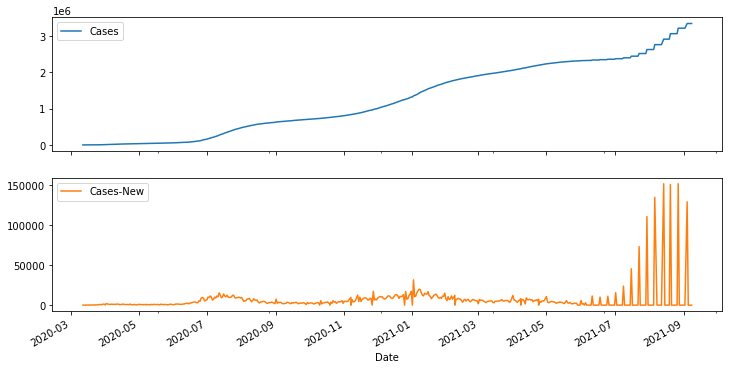

In [20]:
## Plot deaths/cases
cumulative_cols = [c for c in FL.columns for name in ['Daths','Cases']if name in c]
FL[cumulative_cols].plot(subplots=True)

In [21]:
import plotly
plotly.__version__

'5.3.1'

<AxesSubplot:>

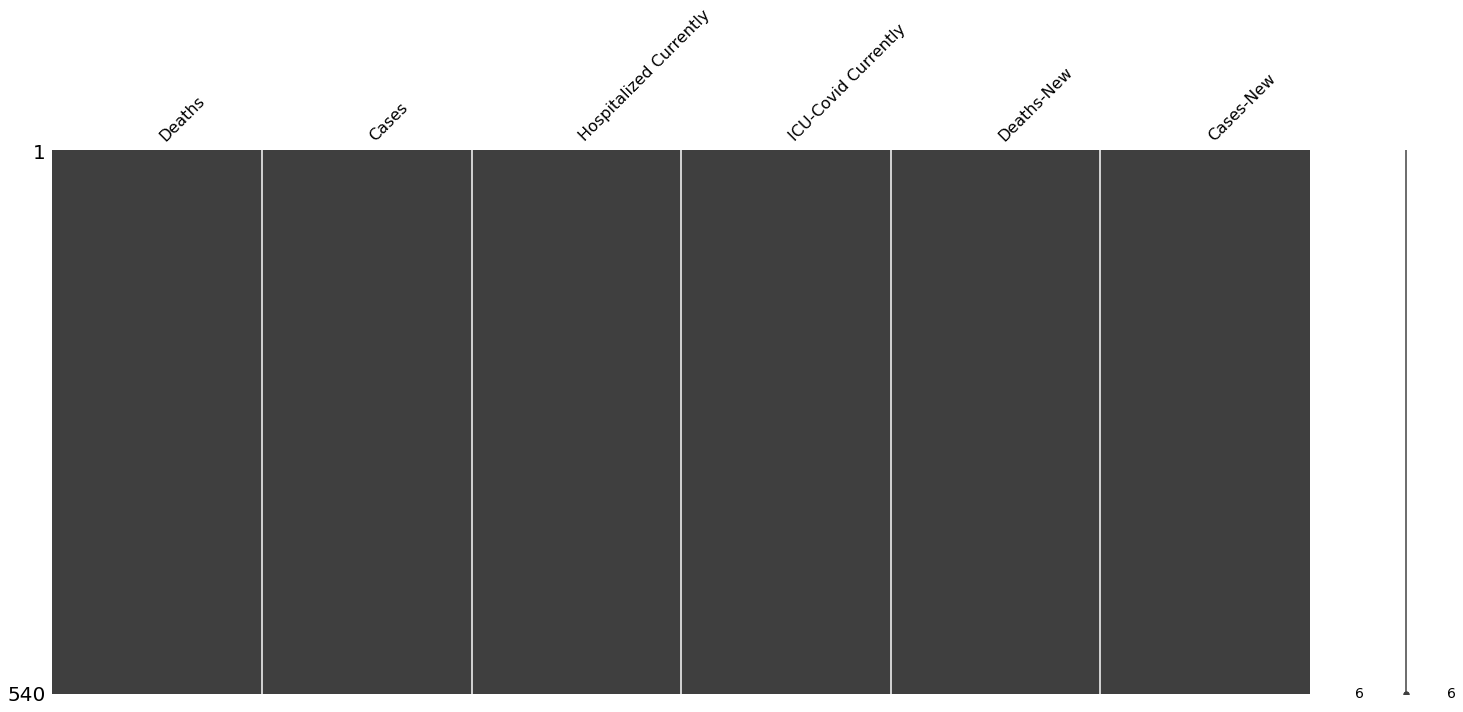

In [22]:
import missingno
missingno.matrix(FL)

In [23]:
# px.imshow(FL.isna(),template='plotly_dark',color_continuous_scale="Reds")

In [24]:
plot_cols = FL.drop(columns=cumulative_cols).columns
plot_cols

Index(['Deaths', 'Hospitalized Currently', 'ICU-Covid Currently',
       'Deaths-New'],
      dtype='object')

In [25]:
import plotly 
plotly.__version__

'5.3.1'

In [26]:
pfig = px.line(FL,y=plot_cols,width=1000,title="FL Data")
pfig.add_vline(first_ts,line_width=3,line_dash="dash",name='Start')
pfig.show()

In [27]:
# raise Exception('end of 09/01/21, though below code is still good.')

# Time Series Modeling

In [28]:
### FORECAST SPECIFIC FUNCTIONS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
import statsmodels.tsa.api as tsa
from pmdarima import auto_arima

## MD

In [29]:
state = "MD"
df_state = STATES[state].loc['08-2020':].copy()
# df_state = df_state.interpolate('time')
# df_state['Deaths-New'] = df_state['Deaths'].diff()
# df_state['Cases-New'] = df_state['Cases'].diff()
df_state = df_state.resample('D').sum()

print(df_state.isna().sum())
df_state

Deaths                    0
Cases                     0
Hospitalized Currently    0
ICU-Covid Currently       0
Deaths-New                0
Cases-New                 0
dtype: int64


,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-08-01,3506,89365,629.0,171.0,13.0,1019.0
2020-08-02,3515,90274,606.0,180.0,9.0,909.0
2020-08-03,3523,91144,574.0,176.0,8.0,870.0
2020-08-04,3530,91854,576.0,191.0,7.0,710.0
2020-08-05,3536,92426,571.0,186.0,6.0,572.0
...,...,...,...,...,...,...
2021-09-04,20122,1004458,1638.0,428.0,10.0,1194.0
2021-09-05,10073,503034,797.0,213.0,12.0,805.0
2021-09-06,10087,504061,799.0,221.0,14.0,1027.0


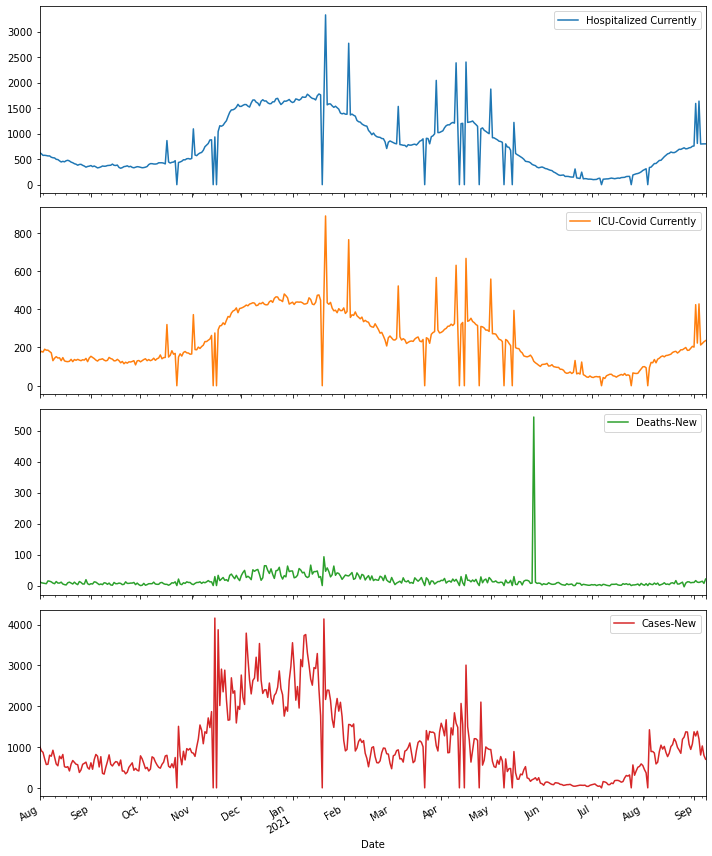

In [30]:
model_cols = ['Hospitalized Currently','ICU-Covid Currently',
              'Deaths-New','Cases-New'
             ]

## visualize
ax = df_state[model_cols].plot(subplots=True, figsize=(10,12))
plt.tight_layout();

#### Data Quality Issues
- There are strong spikes +/- that are not likely to be real values.

### MD - Cases-New

Text(0, 0.5, 'Cases-New')

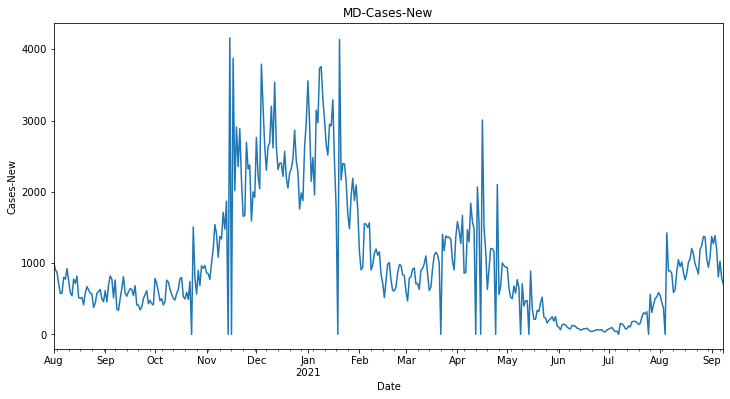

In [31]:
col = 'Cases-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 08-10-2021


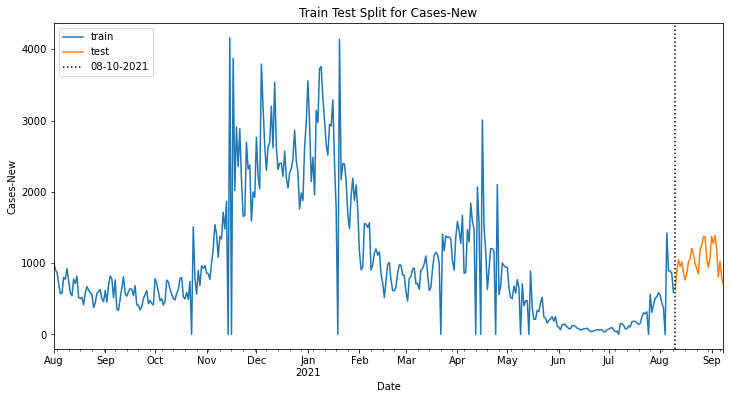

In [32]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

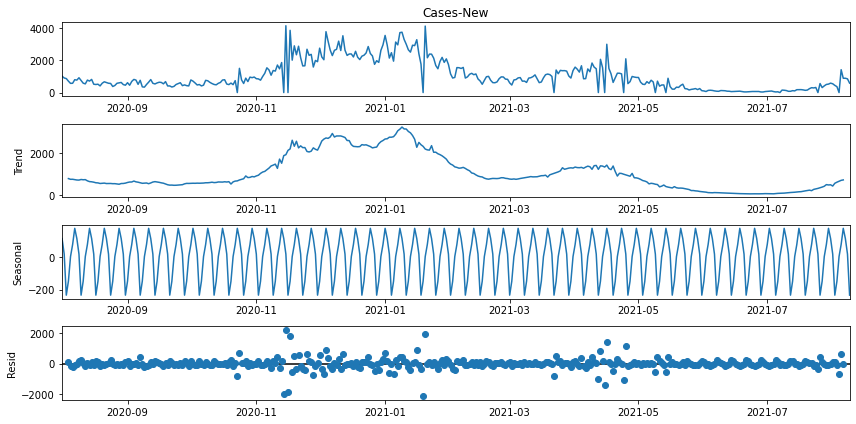

In [33]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

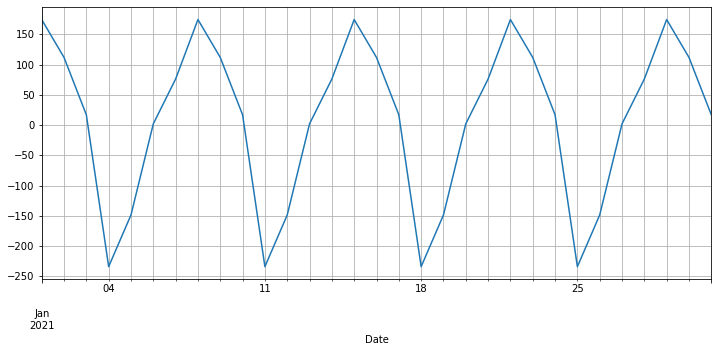

In [34]:
ax = decomp.seasonal.loc['01-2021'].plot(figsize=(12,5))
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.961605,15,351,0.038639,True,True


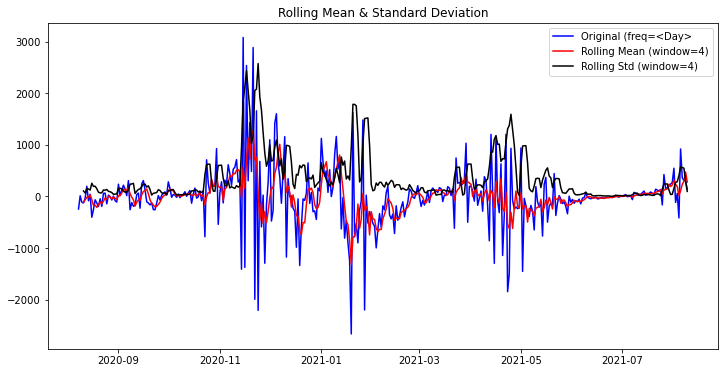

In [35]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

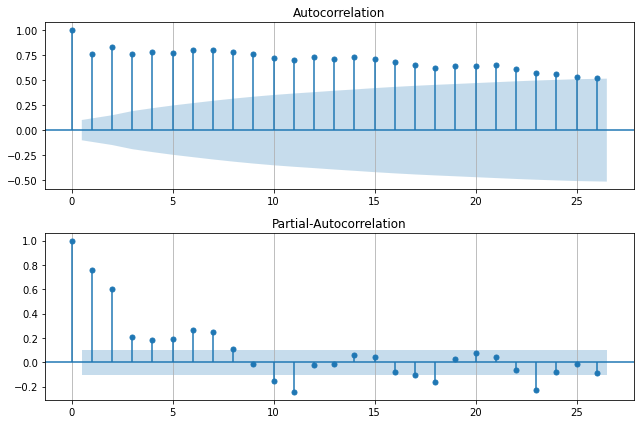

In [36]:
fn.modeling.plot_acf_pacf(train,);

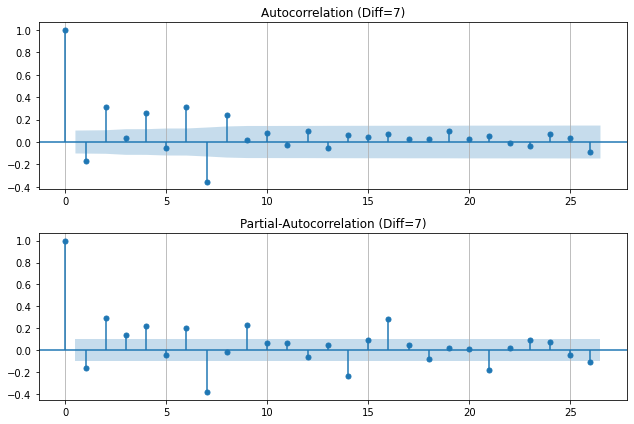

In [37]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [38]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=5716.685, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=5671.629, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5673.278, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=5714.687, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=5708.493, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=5670.689, Time=0.55 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=5672.028, Time=1.13 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=5671.578, Time=0.43 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=5669.687, Time=0.76 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=5669.683, Time=0.29 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=5670.258, Time=0.30 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=5671.490, Time=0.22 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=5670.864, Time=1.11 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=5671.656, Time=0.27 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  374
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2742.882
Date:                           Thu, 09 Sep 2021   AIC                           5497.763
Time:                                   12:07:48   BIC                           5521.195
Sample:                                        0   HQIC                          5507.074
                                           - 374                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0376      1.568     -0.024      0.981      -3.112       3.036
ar.L1          0.5586      0.037     15.270      0.000       0.487       0.630
ar.L2          0.4193      0.032     12.946      0.000       0.356       0.483
ma.L1         -0.6250      0.034    -18.163      0.000      -0.692      -0.558
ma.S.L7       -0.8570      0.031    -27.905      0.000      -0.917      -0.797
sigma2      1.778e+05   6107.430     29.116      0.000    1.66e+05     1.9e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1290.69
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.00
Prob(H) (two-sided):                  0.02   Kurtosis:                        12.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Cases-New   No. Observations:                  374
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2678.205
Date:                           Thu, 09 Sep 2021   AIC                           5366.411
Time:                                   12:07:48   BIC                           5385.813
Sample:                               08-01-2020   HQIC                          5374.127
                                    - 08-09-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5551      0.037     14.888      0.000       0.482       0.628
ar.L2          0.4234      0.032     13.076      0.000       0.360       0.487
ma.L1         -0.6208      0.034    -18.165      0.000      -0.688      -0.554
ma.S.L7       -0.8548      0.032    -27.134      0.000      -0.917      -0.793
sigma2      1.817e+05   6337.837     28.670      0.000    1.69e+05    1.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1197.79
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Cases-New'}, xlabel='Date'>)

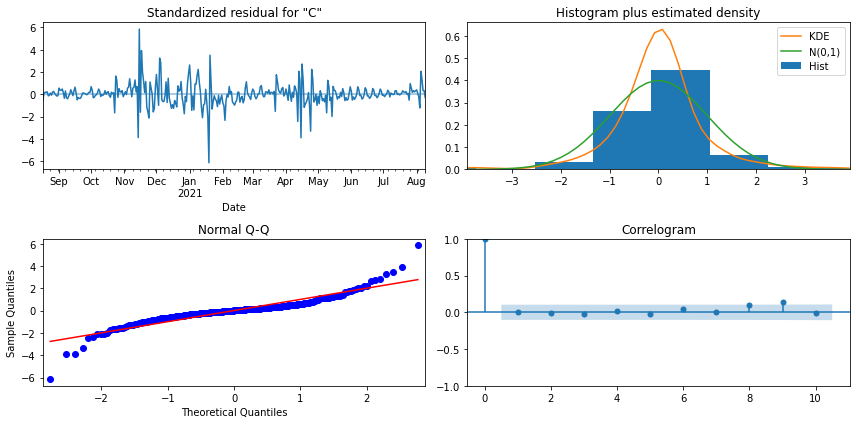

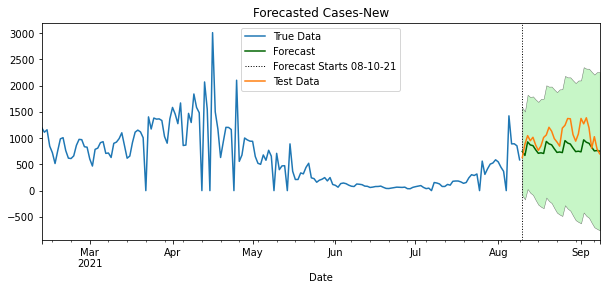

In [39]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Cases-New   No. Observations:                  404
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2889.174
Date:                           Thu, 09 Sep 2021   AIC                           5788.348
Time:                                   12:07:50   BIC                           5808.153
Sample:                               08-01-2020   HQIC                          5796.200
                                    - 09-08-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5589      0.035     16.066      0.000       0.491       0.627
ar.L2          0.4204      0.030     13.863      0.000       0.361       0.480
ma.L1         -0.6182      0.032    -19.416      0.000      -0.681      -0.556
ma.S.L7       -0.8625      0.029    -29.807      0.000      -0.919      -0.806
sigma2      1.696e+05   5492.289     30.874      0.000    1.59e+05     1.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1539.83
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Cases-New'}, xlabel='Date'>)

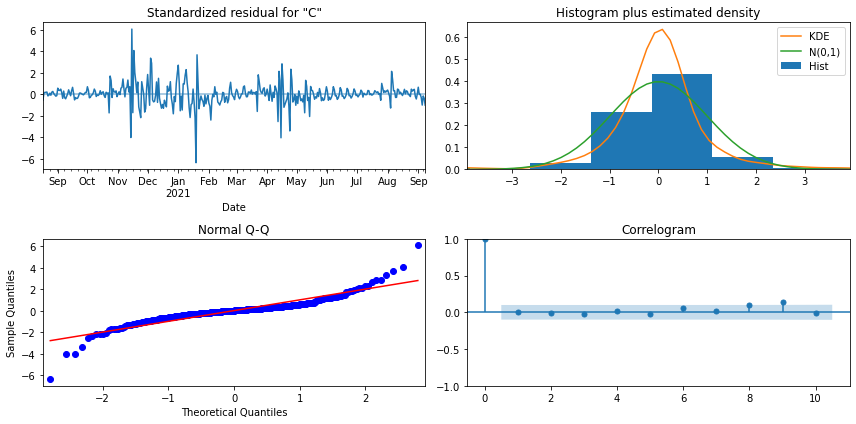

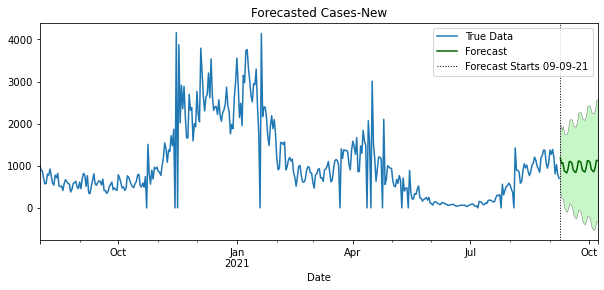

In [40]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

### MD - Hospitalized Currently

In [41]:
# df_state['Hospitalized Currently']

Text(0, 0.5, 'Hospitalized Currently')

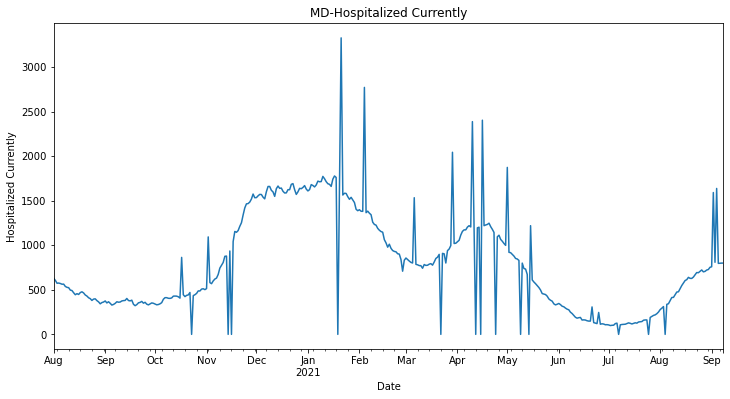

In [42]:
col = 'Hospitalized Currently'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 08-10-2021


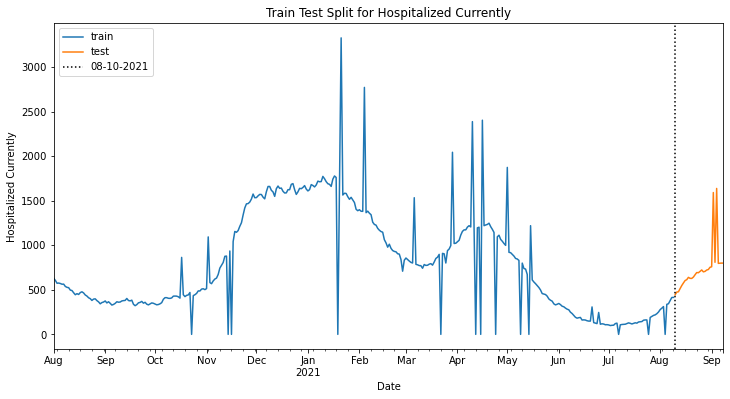

In [43]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

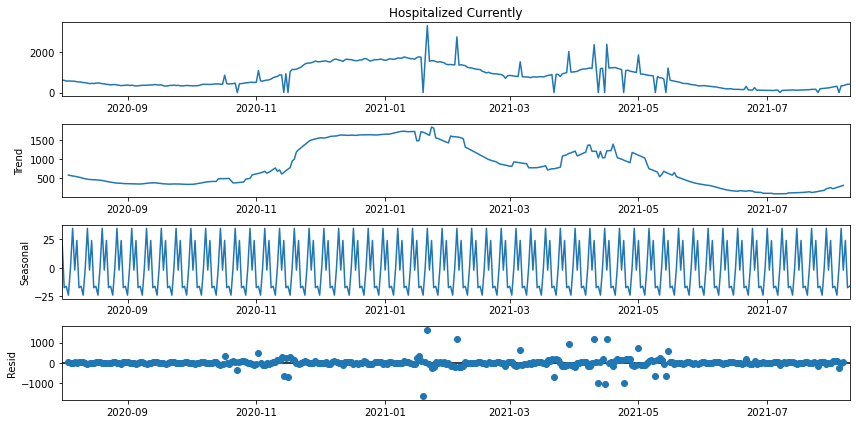

In [44]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

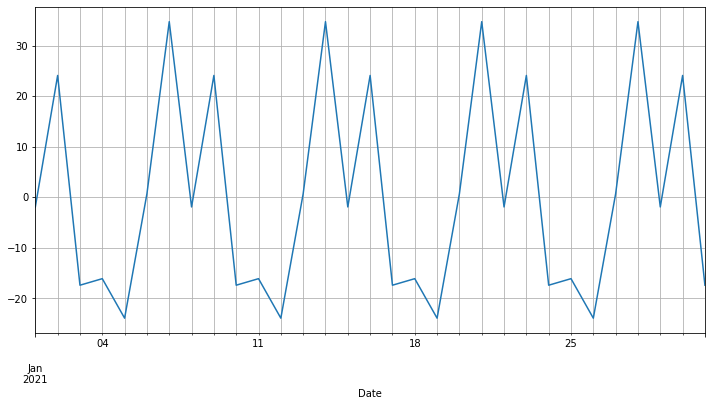

In [45]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-3.912444,13,353,0.001945,True,True


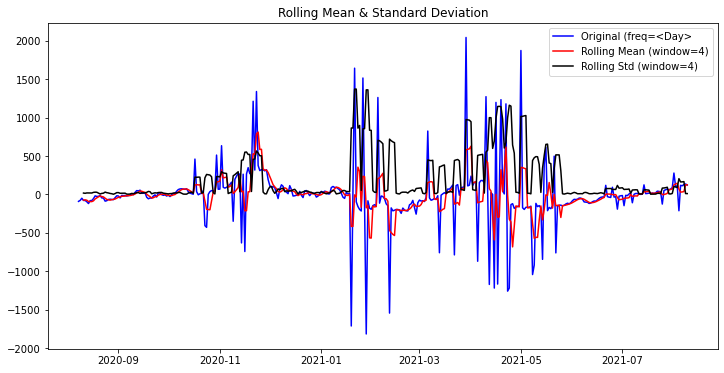

In [46]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

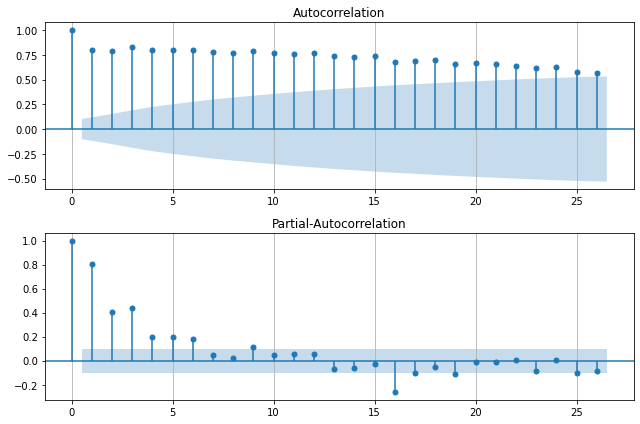

In [47]:
fn.modeling.plot_acf_pacf(train,);

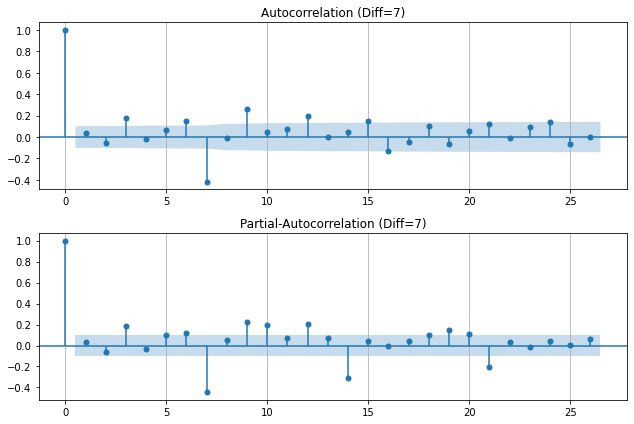

In [48]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [49]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=5404.402, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=5333.276, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5324.520, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=5402.469, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=5405.818, Time=0.07 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=5323.443, Time=0.51 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=5333.822, Time=0.39 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=5320.858, Time=1.64 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=5319.511, Time=0.78 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=5329.783, Time=1.40 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=5255.757, Time=2.96 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=5304.382, Time=1.55 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=3.47 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=5

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning:

Error fitting  ARIMA(3,0,2)(2,1,1)[7]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  374
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 7)   Log Likelihood               -2599.122
Date:                             Thu, 09 Sep 2021   AIC                           5218.245
Time:                                     12:10:03   BIC                           5257.298
Sample:                                          0   HQIC                          5233.762
                                             - 374                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0047      0.036     -0.129      0.898      -0.076       0.067
ar.L1          1.9165      0.083     23.154      0.000       1.754       2.079
ar.L2         -0.8577      0.136     -6.318      0.000      -1.124      -0.592
ar.L3         -0.0589      0.065     -0.903      0.367      -0.187       0.069
ma.L1         -1.7954      0.057    -31.609      0.000      -1.907      -1.684
ma.L2          0.8077      0.047     17.009      0.000       0.715       0.901
ar.S.L7       -0.0251      0.076     -0.330      0.742      -0.174       0.124
ar.S.L14       0.0179      0.052      0.346      0.729      -0.083       0.119
ma.S.L7       -0.9109      0.057    -15.941      0.000      -1.023      -0.799
sigma2      1.004e+05   4066.683     24.689      0.000    9.24e+04    1.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              4817.02
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               3.36   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              Hospitalized Currently   No. Observations:                  374
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 7)   Log Likelihood               -2492.376
Date:                             Thu, 09 Sep 2021   AIC                           5002.751
Time:                                     12:10:07   BIC                           5037.472
Sample:                                 08-01-2020   HQIC                          5016.571
                                      - 08-09-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8835      0.106     17.754      0.000       1.676       2.091
ar.L2         -0.8429      0.183     -4.603      0.000      -1.202      -0.484
ar.L3         -0.0425      0.086     -0.493      0.622      -0.211       0.126
ma.L1         -1.8313      0.055    -33.395      0.000      -1.939      -1.724
ma.L2          0.8632      0.047     18.329      0.000       0.771       0.955
ar.S.L7       -0.1565      0.091     -1.713      0.087      -0.336       0.023
ar.S.L14      -0.0698      0.065     -1.071      0.284      -0.198       0.058
ma.S.L7       -0.9071      0.062    -14.685      0.000      -1.028      -0.786
sigma2      1.288e+05   6273.922     20.533      0.000    1.17e+05    1.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              3765.72
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Hospitalized Currently'}, xlabel='Date'>)

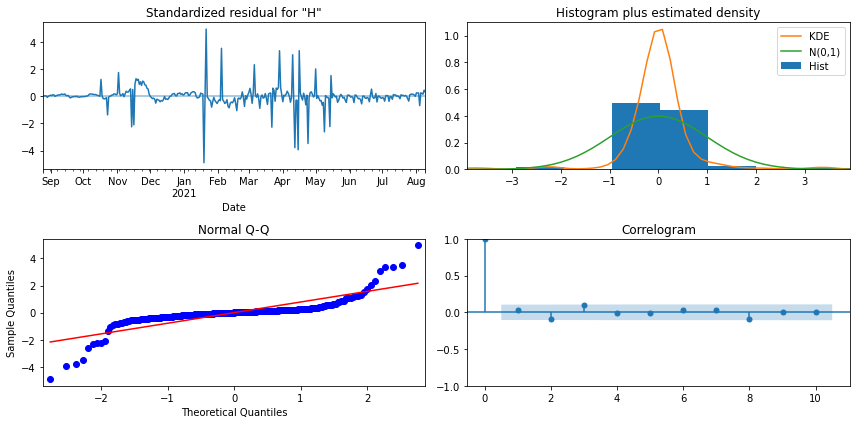

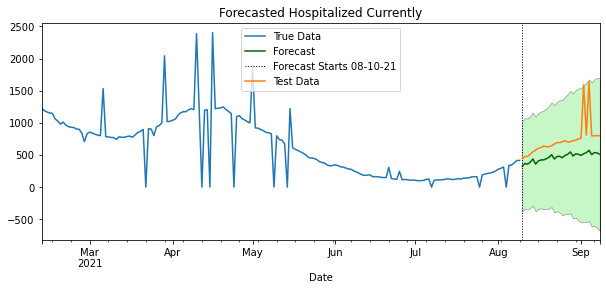

In [50]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              Hospitalized Currently   No. Observations:                  404
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 7)   Log Likelihood               -2690.892
Date:                             Thu, 09 Sep 2021   AIC                           5399.783
Time:                                     12:10:12   BIC                           5435.245
Sample:                                 08-01-2020   HQIC                          5413.854
                                      - 09-08-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0072      0.060      0.121      0.904      -0.110       0.124
ar.L2          0.9522      0.049     19.547      0.000       0.857       1.048
ar.L3          0.0237      0.067      0.355      0.723      -0.107       0.155
ma.L1          0.2049      0.063      3.272      0.001       0.082       0.328
ma.L2         -0.8082      0.048    -16.681      0.000      -0.903      -0.713
ar.S.L7       -0.1360      0.064     -2.115      0.034      -0.262      -0.010
ar.S.L14       0.0102      0.041      0.245      0.806      -0.071       0.091
ma.S.L7       -0.9729      0.058    -16.720      0.000      -1.087      -0.859
sigma2      9.003e+04   8693.386     10.356      0.000     7.3e+04    1.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              3453.78
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.28
Prob(H) (two-sided):                  0.58   Kurtosis:                        17.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Hospitalized Currently'}, xlabel='Date'>)

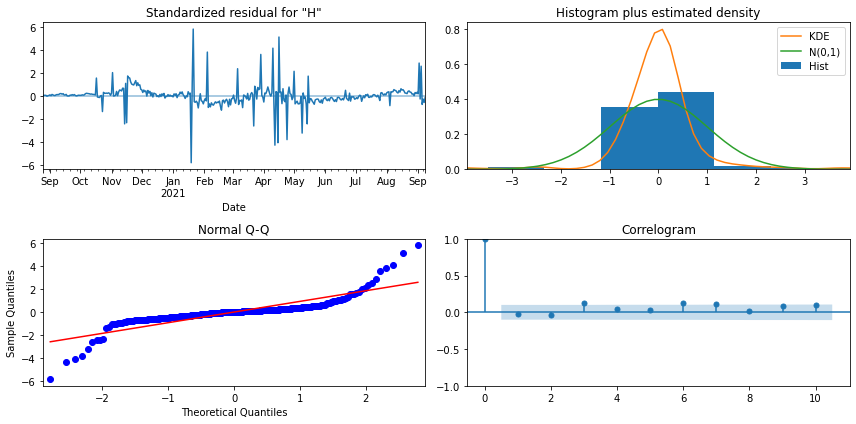

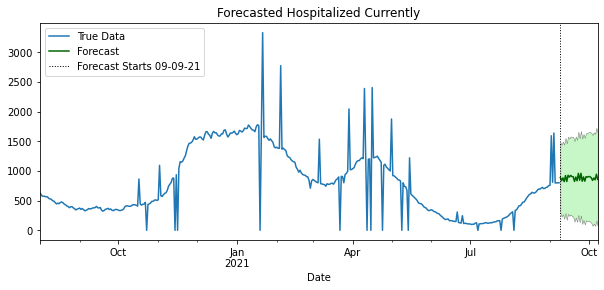

In [51]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

## 🚨 BOOKMARK: Data Quality Issue - Deaths

- To Do: Remove outliers.
    - Try using .diff() and a high threshold for deterining outliers

### MD - Deaths-New

Text(0, 0.5, 'Deaths-New')

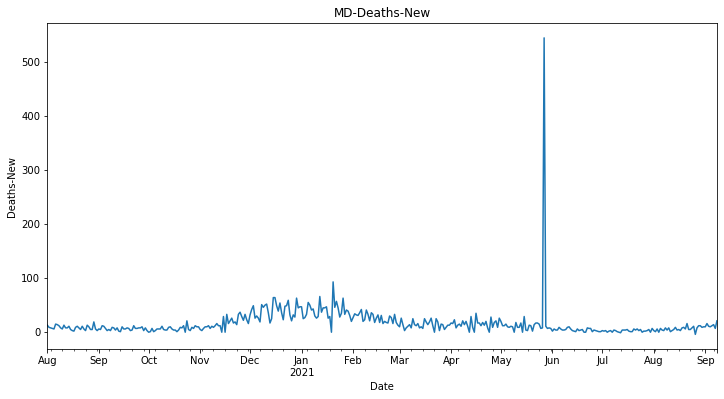

In [52]:
col = 'Deaths-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

In [53]:
## saving deltas 
deltas  = ts.diff()

## SSaving outleirs
threshold=100
outliers = deltas[deltas.abs()>threshold]
outliers

Date
2021-05-27    536.0
2021-05-28   -533.0
Freq: D, Name: Deaths-New, dtype: float64

In [54]:
# outliers= deltas[deltas.abs()>threshold]
# outliers

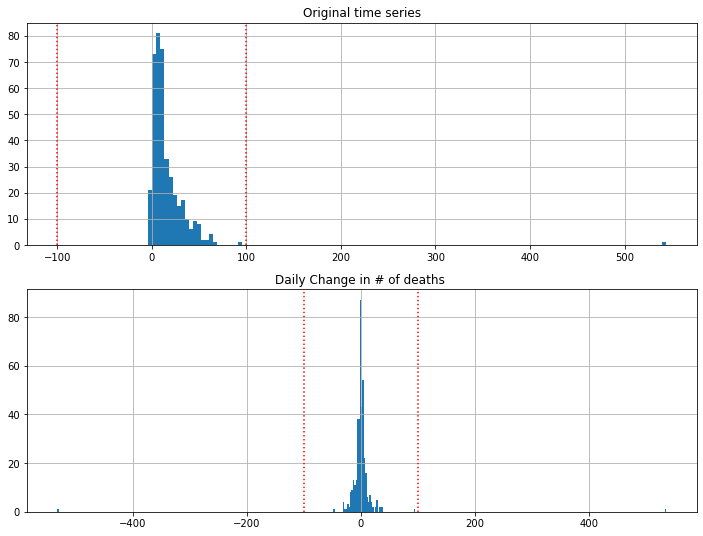

In [55]:
## saving deltas 
fig, axes = plt.subplots(nrows=2,figsize=(12,9))
ax0 = ts.hist(bins='auto',ax=axes[0])
ax0.set(title='Original time series')

## saving deltas 
ax1 = deltas.hist(bins='auto',ax=axes[1])
ax1.set(title='Daily Change in # of deaths ');

for ax in axes:
    ax.axvline(threshold,ls=':',c='red')
    ax.axvline(-threshold,ls=':',c='red')

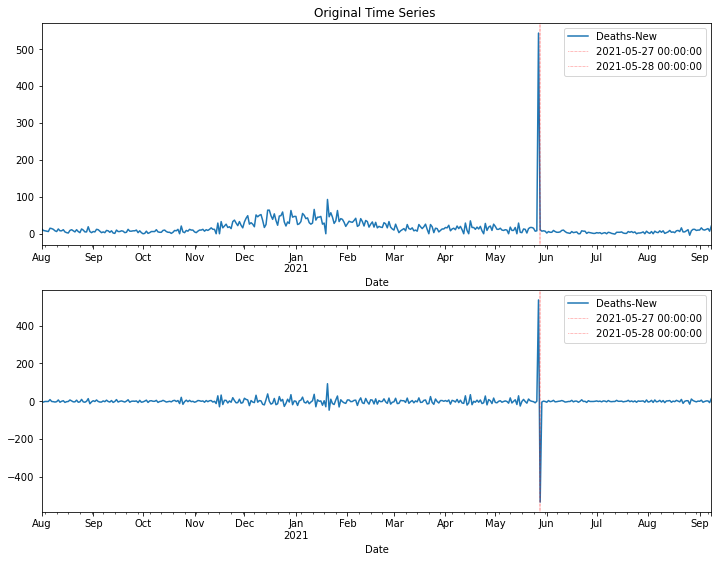

In [56]:
## Plotting High Deltas on original time seires

## saving deltas 
fig, axes = plt.subplots(nrows=2,figsize=(12,9))

ax =axes[0]
ts.plot(ax = ax)
ax.set(title='Original Time Series ')

deltas.plot(ax=axes[1])
for ax in axes:
    [ax.axvline(x_val,label=x_val,lw=0.5,ls = ':',color='red') for x_val in outliers.index]
    ax.legend()



> The issues seem to be entirely in the deltas and therefore 

<AxesSubplot:xlabel='Date'>

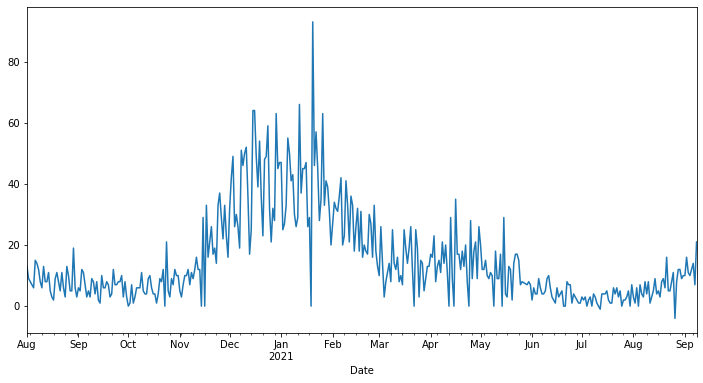

In [57]:
## saving deltas 
deltas  = ts.diff()

## SSaving outleirs
threshold=100
outliers = deltas[deltas.abs()>threshold]


## Filling in outliers
ts.loc[outliers.index] = np.nan
ts.interpolate(inplace=True)
ts.plot()

<AxesSubplot:xlabel='Date'>

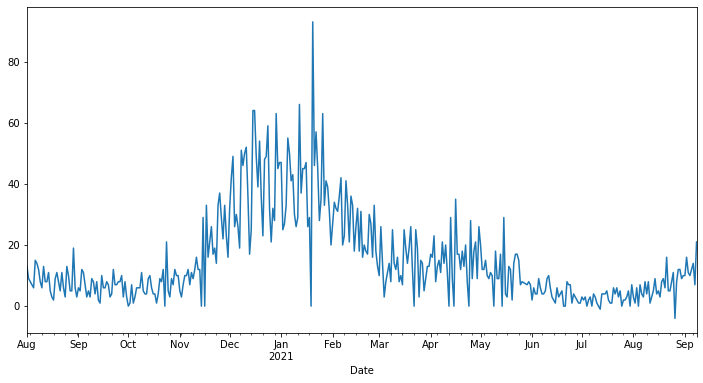

In [58]:

## Filling in outliers
ts.loc[outliers.index] = np.nan
ts.interpolate(inplace=True)
ts.plot()

In [59]:
# raise Exception('Deal with the data quality issue above')

#### Train Test Split

Using a cutoff index of -30, which = 08-10-2021


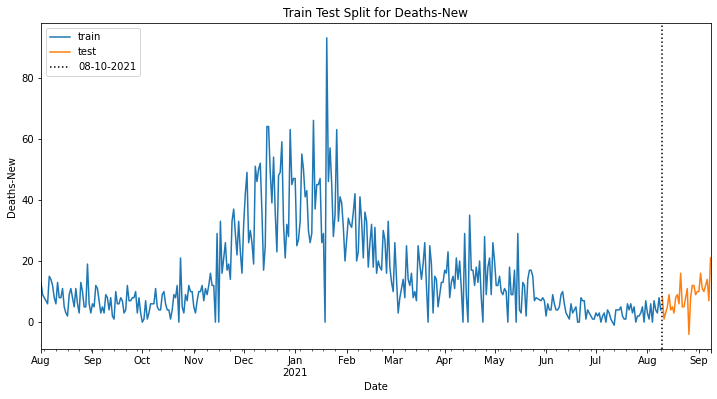

In [60]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

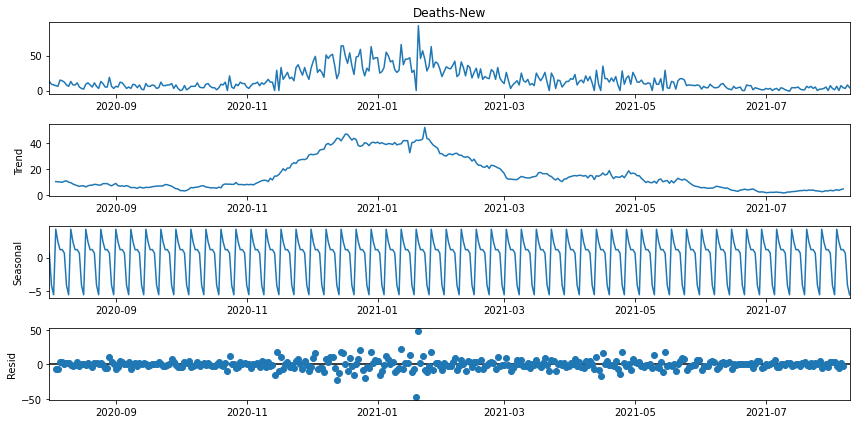

In [61]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

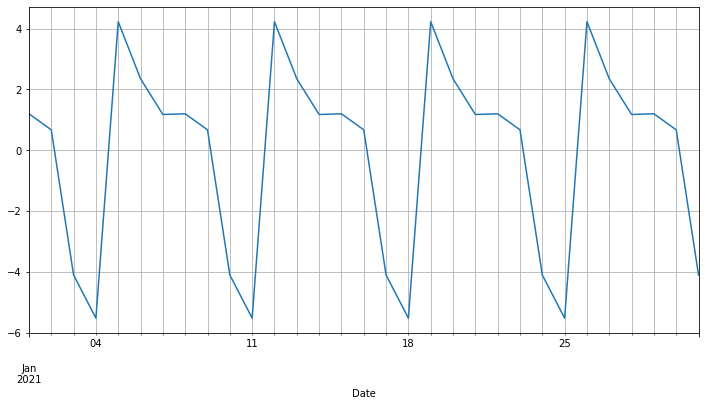

In [62]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-3.220879,15,351,0.018808,True,True


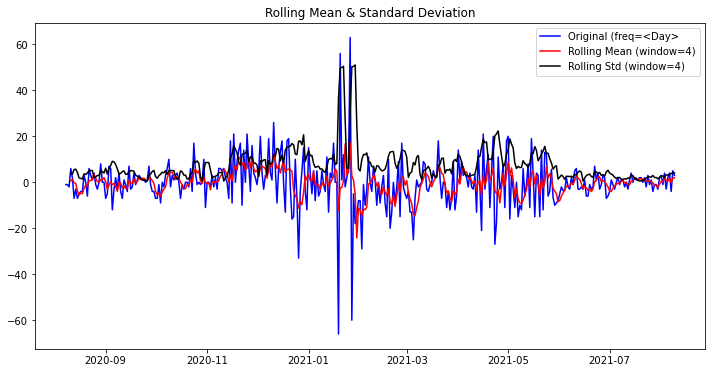

In [63]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

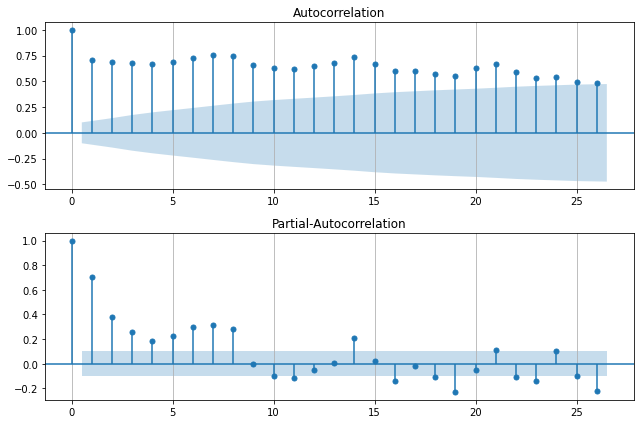

In [64]:
fn.modeling.plot_acf_pacf(train,);

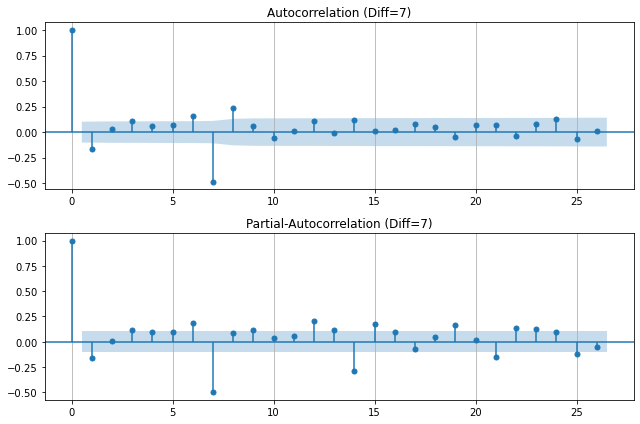

In [65]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [66]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=2769.127, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=2676.016, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=2681.925, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=2767.166, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=2761.468, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=2668.583, Time=0.50 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=2669.499, Time=1.07 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=2671.430, Time=0.25 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=2667.811, Time=0.49 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=2674.068, Time=0.17 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=2668.274, Time=0.69 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=2670.213, Time=0.31 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=2669.012, Time=0.56 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=2610.012, Time=0.97 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  374
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -1279.558
Date:                             Thu, 09 Sep 2021   AIC                           2573.116
Time:                                     12:11:42   BIC                           2600.454
Sample:                                          0   HQIC                          2583.978
                                             - 374                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6533      0.116     14.218      0.000       1.425       1.881
ar.L2         -0.6604      0.115     -5.729      0.000      -0.886      -0.434
ma.L1         -1.6442      0.115    -14.339      0.000      -1.869      -1.419
ma.L2          0.7180      0.100      7.162      0.000       0.521       0.914
ar.S.L7       -0.1904      0.053     -3.590      0.000      -0.294      -0.086
ma.S.L7       -0.7272      0.045    -16.056      0.000      -0.816      -0.638
sigma2        61.4167      2.712     22.646      0.000      56.101      66.732
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1431.54
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.54
Prob(H) (two-sided):                  0.72   Kurtosis:                        12.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Deaths-New   No. Observations:                  374
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -1247.924
Date:                             Thu, 09 Sep 2021   AIC                           2509.847
Time:                                     12:11:43   BIC                           2536.991
Sample:                                 08-01-2020   HQIC                          2520.644
                                      - 08-09-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5728      0.130     12.129      0.000       1.319       1.827
ar.L2         -0.5813      0.128     -4.531      0.000      -0.833      -0.330
ma.L1         -1.5818      0.129    -12.223      0.000      -1.835      -1.328
ma.L2          0.6709      0.114      5.909      0.000       0.448       0.893
ar.S.L7       -0.2130      0.056     -3.794      0.000      -0.323      -0.103
ma.S.L7       -0.7073      0.049    -14.327      0.000      -0.804      -0.611
sigma2        62.8570      2.859     21.982      0.000      57.253      68.461
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1333.15
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.65
Prob(H) (two-sided):                  0.27   Kurtosis:                        12.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

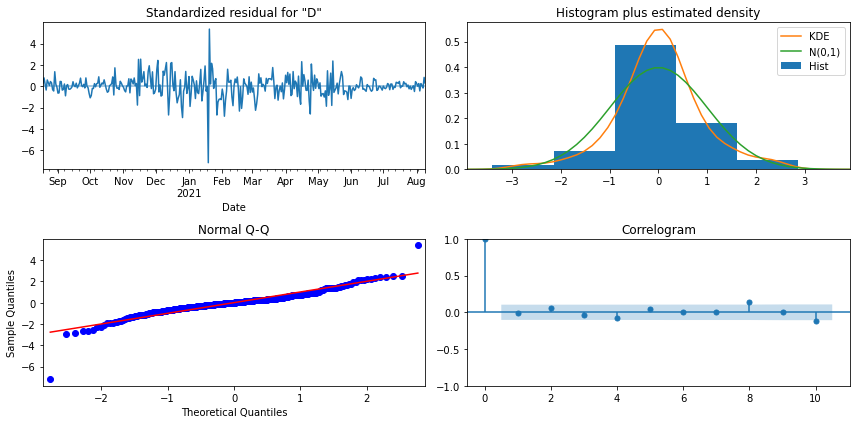

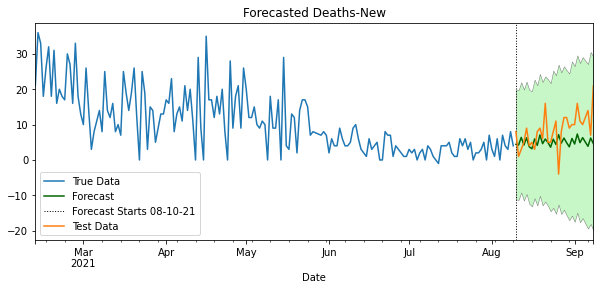

In [67]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Deaths-New   No. Observations:                  404
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -1342.125
Date:                             Thu, 09 Sep 2021   AIC                           2698.249
Time:                                     12:11:45   BIC                           2725.958
Sample:                                 08-01-2020   HQIC                          2709.236
                                      - 09-08-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5820      0.118     13.407      0.000       1.351       1.813
ar.L2         -0.5899      0.117     -5.046      0.000      -0.819      -0.361
ma.L1         -1.5909      0.117    -13.541      0.000      -1.821      -1.361
ma.L2          0.6783      0.103      6.578      0.000       0.476       0.880
ar.S.L7       -0.2136      0.053     -4.044      0.000      -0.317      -0.110
ma.S.L7       -0.7108      0.046    -15.503      0.000      -0.801      -0.621
sigma2        59.5265      2.537     23.466      0.000      54.555      64.498
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1561.47
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

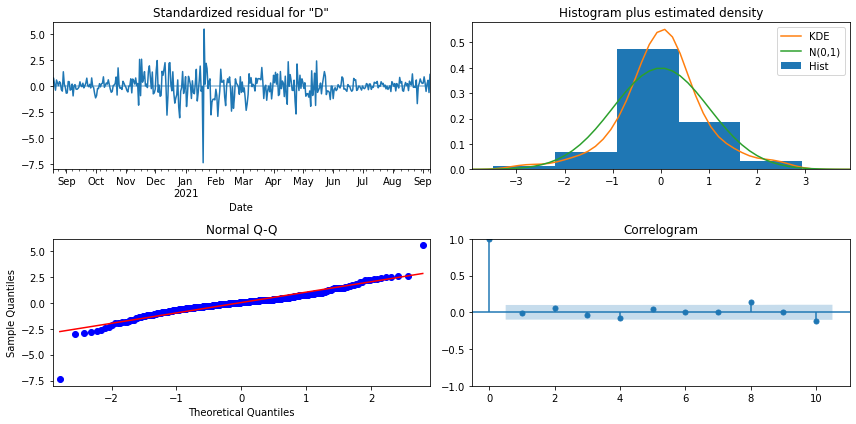

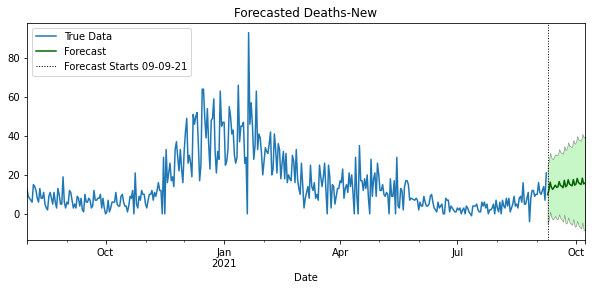

In [68]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

# Function For Any Given State/ Column

In [69]:
state = "NY"
col = 'Deaths'#'Hospitalized Currently'
start_date='08-2020'
remove_outliers=True
threshold=100
plot=True


df_state = STATES[state].loc[start_date:].copy()
df_state = df_state.resample('D').sum()
ts = df_state[col].copy()
ts.index.name='Datetime'

# ts = ts.resample('D').asfreq()
ts

Datetime
2020-08-01    32517
2020-08-02    32530
2020-08-03    32530
2020-08-04    32536
2020-08-05    32569
              ...  
2021-09-04    54378
2021-09-05    54420
2021-09-06    54449
2021-09-07    54481
2021-09-08    54500
Freq: D, Name: Deaths, Length: 404, dtype: int64

## **✔ TO DO: make remove_outliers into a helper function**

```python
## TO DO: make remove_outliers into a helper function
if remove_outliers:
    ## saving deltas 
    deltas  = ts.diff()

    ## SSaving outleirs
    outliers = deltas[deltas.abs()>threshold]


    ## Filling in outliers
    ts.loc[outliers.index] = np.nan
    ts.interpolate(inplace=True)
```


In [70]:
def remove_outliers_ts(ts,threshold_type='raw',threshold=100, n_diff=1):
    ## saving deltas 
    deltas  = ts.diff(n_diff)
    
    
    ## Criterion
    if threshold_type=='raw':
        idx_outliers = deltas.abs()>threshold
        
#     elif threshold_type :
#         pass
    else:
        raise Exception("threshold_kinds are not yet implemented")
        pass
    ## SSaving outleirs
    outliers = deltas[idx_outliers]


    ## Filling in outliers
    ts.loc[outliers.index] = np.nan
    ts_out = ts.interpolate()
    
    return ts_out
     
    


<AxesSubplot:xlabel='Date'>

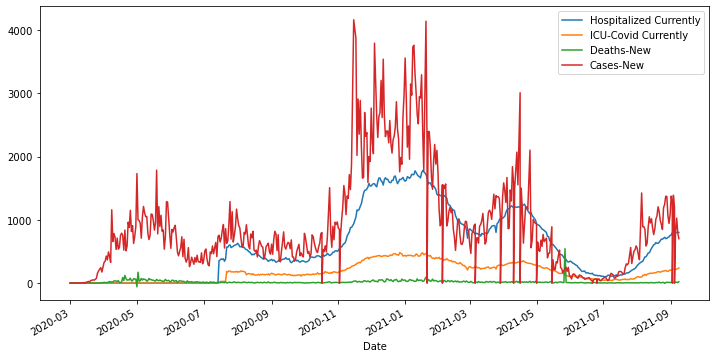

In [71]:
## test function
ts = STATES['MD'].copy()
ts.drop(['Deaths','Cases'],1).plot()

<AxesSubplot:xlabel='Date'>

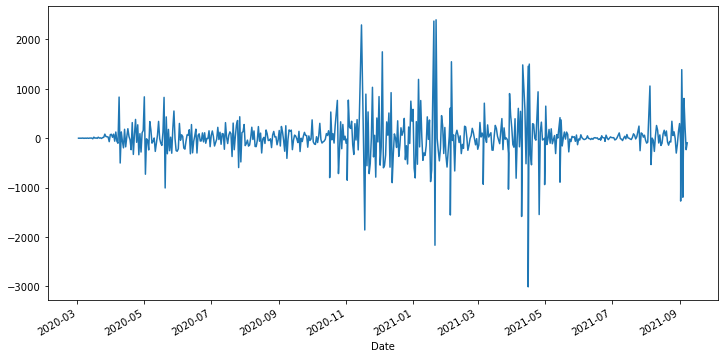

In [72]:
ts['Cases-New'].diff().plot()

In [73]:
def make_timeseries_model(STATES,state = "MD",col = 'Cases-New',
                          start_date='08-2020',
                         remove_outliers=True,threshold=100,
                         plot=True):
    ## Slicing out state df for index dates 
    df_state = STATES[state].loc[start_date:].copy()
    df_state = df_state.resample('D').sum()
    ts = df_state[col].copy()

    ## Outlier removal 
    if remove_outliers:
        ## saving deltas 
        deltas  = ts.diff()

        ## SSaving outleirs
        outliers = deltas[deltas.abs()>threshold]


        ## Filling in outliers
        ts.loc[outliers.index] = np.nan
        ts.interpolate(inplace=True)
    
    if plot:
        ax = ts.plot(title=f"{state}-{col}");
        ax.set_ylabel(col)
        display(ax.get_figure())
        
        

    from pmdarima import auto_arima
    train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)
    
    auto_model = auto_arima(train,m=7,trace=True,D=1,
                            start_p=0, start_q=0,
                            start_P=0, start_Q=0)
    display(auto_model.summary())
        
    model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

    fn.modeling.evaluate_model(model,train,test,last_n_lags=180)
    
    
    model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
    fn.modeling.diagnose_model(model)
    fn.modeling.plot_forecast(model, ts)
    
    return ts, model
    

In [74]:
STATES['NY']

,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-03-14,5,557,0.0,0.0,0.0,0.0
2020-03-15,10,633,0.0,0.0,5.0,76.0
2020-03-16,21,961,0.0,0.0,11.0,328.0
2020-03-17,35,1407,0.0,0.0,14.0,446.0
2020-03-18,60,2507,0.0,0.0,25.0,1100.0
...,...,...,...,...,...,...
2021-09-04,54378,2297642,2276.0,560.0,17.0,3676.0
2021-09-05,54420,2303739,2308.0,546.0,42.0,6097.0
2021-09-06,54449,2307414,2356.0,543.0,29.0,3675.0


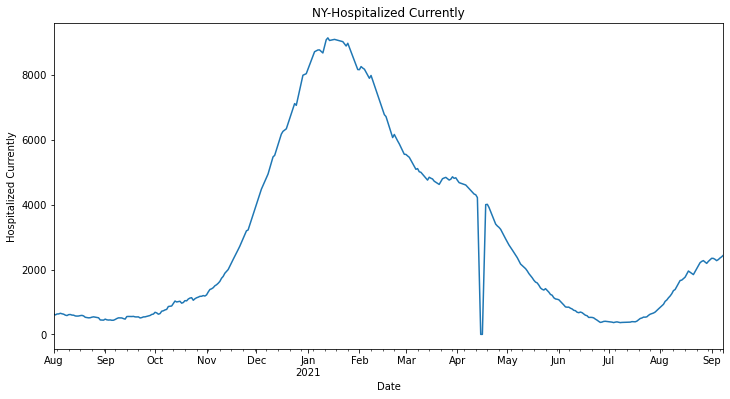

Using a cutoff index of -30, which = 08-10-2021
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5236.062, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5031.243, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=5133.344, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=4995.827, Time=0.28 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=5103.114, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=4807.317, Time=0.37 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=4840.167, Time=0.24 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.07 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=4801.902, Time=0.67 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=4830.176, Time=0.36 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  374
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -2394.951
Date:                           Thu, 09 Sep 2021   AIC                           4801.902
Time:                                   12:12:02   BIC                           4825.318
Sample:                                        0   HQIC                          4811.207
                                           - 374                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9317      0.042     21.979      0.000       0.849       1.015
ar.L2         -0.7673      0.041    -18.899      0.000      -0.847      -0.688
ar.L3          0.1577      0.041      3.863      0.000       0.078       0.238
ar.S.L7       -0.5765      0.034    -17.038      0.000      -0.643      -0.510
ar.S.L14      -0.2785      0.019    -14.455      0.000      -0.316      -0.241
sigma2      2.797e+04    392.574     71.250      0.000    2.72e+04    2.87e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             75596.25
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              32.48   Skew:                            -3.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        73.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:            Hospitalized Currently   No. Observations:                  374
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -2289.878
Date:                           Thu, 09 Sep 2021   AIC                           4591.755
Time:                                   12:12:02   BIC                           4614.886
Sample:                               08-01-2020   HQIC                          4600.963
                                    - 08-09-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9329      0.045     20.709      0.000       0.845       1.021
ar.L2         -0.7702      0.043    -17.828      0.000      -0.855      -0.686
ar.L3          0.1581      0.043      3.639      0.000       0.073       0.243
ar.S.L7       -0.5864      0.036    -16.422      0.000      -0.656      -0.516
ar.S.L14      -0.2885      0.020    -14.356      0.000      -0.328      -0.249
sigma2      2.928e+04    431.532     67.849      0.000    2.84e+04    3.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             66052.36
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              15.56   Skew:                            -3.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:            Hospitalized Currently   No. Observations:                  404
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -2472.209
Date:                           Thu, 09 Sep 2021   AIC                           4956.418
Time:                                   12:12:03   BIC                           4980.043
Sample:                               08-01-2020   HQIC                          4965.793
                                    - 09-08-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9310      0.041     22.455      0.000       0.850       1.012
ar.L2         -0.7675      0.040    -19.264      0.000      -0.846      -0.689
ar.L3          0.1564      0.040      3.904      0.000       0.078       0.235
ar.S.L7       -0.5869      0.033    -17.789      0.000      -0.652      -0.522
ar.S.L14      -0.2892      0.019    -15.534      0.000      -0.326      -0.253
sigma2      2.712e+04    369.609     73.378      0.000    2.64e+04    2.78e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             82795.40
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -3.59
Prob(H) (two-sided):                  0.07   Kurtosis:                        75.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

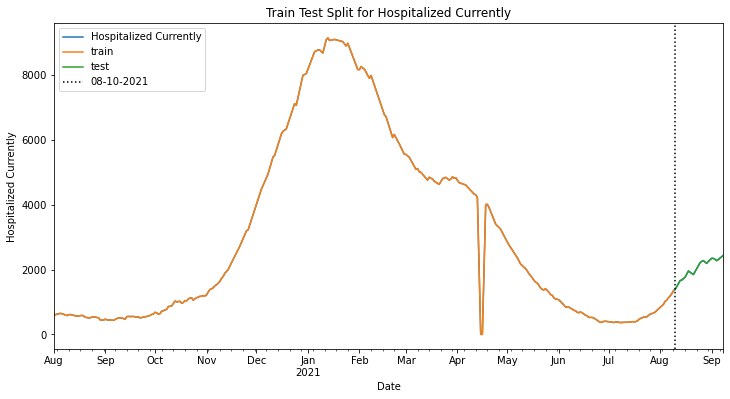

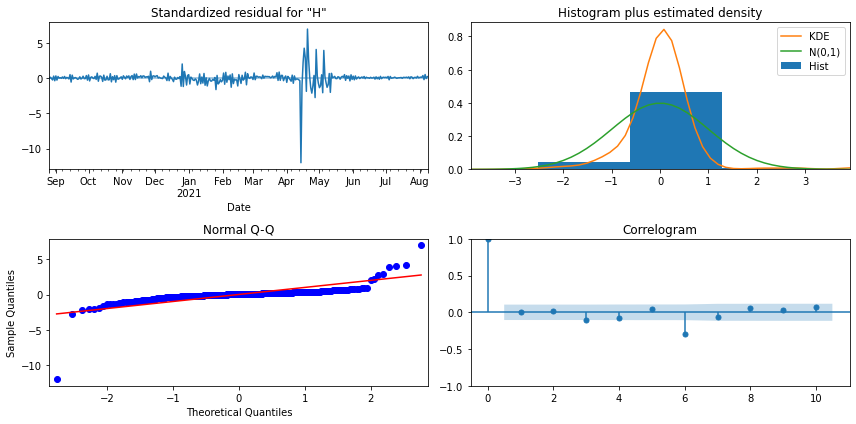

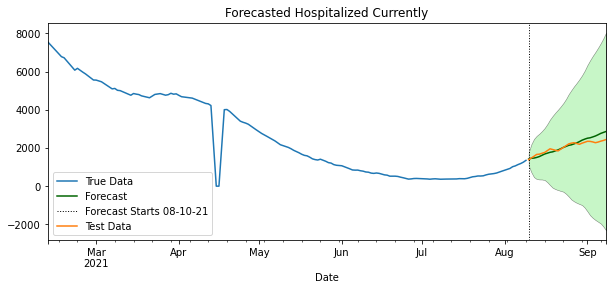

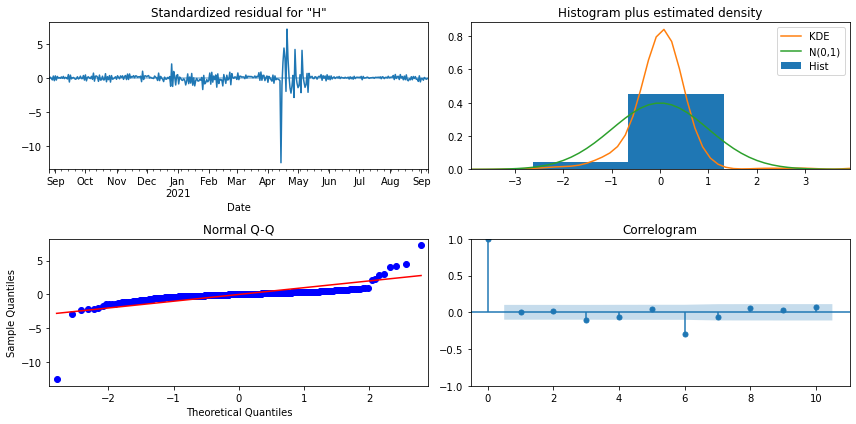

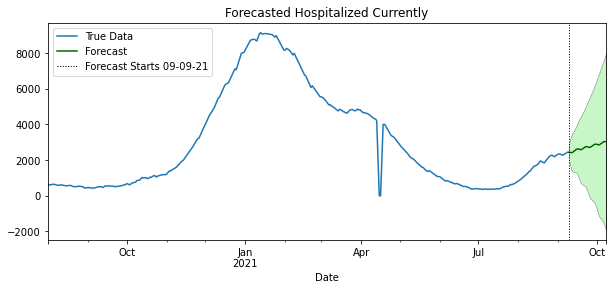

In [75]:
ts,model = make_timeseries_model(STATES,'NY','Hospitalized Currently')

# `@interact`

In [76]:
from ipywidgets import interact
import datetime as dt

@interact
def get_model(state=list(STATES.keys()),
             col=list(STATES['NY'].columns),model=False):
    if model:
        start = dt.datetime.now()
        ts,model = make_timeseries_model(STATES,state,col)
        end = dt.datetime.now()
        print(f'Modeling Process took {end-start} sec.')

interactive(children=(Dropdown(description='state', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', '…

# APPENDIX

### `def` modeling functions

In [77]:
# def train_test_split_ts(ts,test_size=0.9,split_index=None):
#     """Uses test size by default, split_index overrides it"""
#     if split_index is not None:
#         tts_cutoff = split_index
#     else:
#         tts_cutoff = round(ts.shape[0]*0.9)
#     fmt = "%m-%d-%Y"
#     cutoff_time = ts.index[tts_cutoff]
#     print(f"Using a cutoff index of {tts_cutoff}, which = {cutoff_time.strftime(fmt)}")
    
#       ## Use the tts cutoff to do Train test split and plot
#     train = ts.iloc[:tts_cutoff]
#     test = ts.iloc[tts_cutoff:]

#     ## Plot
#     ax = train.plot(label='train')
#     test.plot(label='test')
#     ax.legend()
#     ax.set(ylabel=ts.name)
#     ax.axvline(cutoff_time,color='k',ls=':',label=cutoff_time.strftime(fmt))
#     ax.legend()
#     ax.set_title(f"Train Test Split for {ts.name}")
#     return train, test


In [78]:
# ## funtionize diagnosing
# def diagnose_model(model): #keep
#     """Takes a fit statsmodels model and displays the .summary 
#     and plots the built-in plot.diagnostics()"""
#     display(model.summary())
#     model.plot_diagnostics()
#     plt.tight_layout()
    
    
# def get_forecast(model,steps=14): #keep
#     forecast = model.get_forecast(steps=steps)
#     forecast_df = forecast.conf_int()
#     forecast_df['Forecast'] = forecast.predicted_mean
#     forecast_df.columns = ['Lower CI','Upper CI','Forecast']
#     return forecast_df


# def plot_forecast(forecast_df,ts,orig_label='True Data',
#                   forecast_label='Forecast',
#                   forecast_steps=30,
#                   last_n_lags=None,figsize=(10,4)):
#     """Takes a forecast_df from get_df_from_pred and optionally 
#     the training/original time series.
    
#     Plots the original ts, the predicted mean and the 
#     confidence invtervals (using fill between)"""
#     if not isinstance(forecast_df,pd.DataFrame):
#         forecast_df = get_forecast(forecast_df,steps=forecast_steps)
        
#     fig,ax = plt.subplots(figsize=figsize)

#     if last_n_lags is None:
#         last_n_lags = len(ts)
        
#     ts.iloc[-last_n_lags:].plot(label='True Data')

    
#     forecast_df['Forecast'].plot(ax=ax,color='darkgreen',label=forecast_label)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['Lower CI'], 
#                     forecast_df['Upper CI'],
#                     color='lightgreen',alpha=0.5,lw=0.5,edgecolor='k')
#     ax.set(title=f'Forecasted {ts.name}')
#     sep = forecast_df.index[0]
#     ax.axvline(sep,label=f"Forecast Starts {sep.strftime('%m-%d-%y')}",lw=1,ls=':',c='k')
#     ax.legend()

#     return fig,ax

    
# def evaluate_model(model,train,test,steps=None,last_n_lags=None):
#     diagnose_model(model)
    
#     if steps is None:
#         steps=len(test)
        
#     forecast_df = get_forecast(model,steps=len(test))
#     fig, ax = plot_forecast(forecast_df,train,last_n_lags=last_n_lags)
    
#     test.plot(ax=ax,label='Test Data')
#     ax.legend()
#     return fig,ax
           
 
